### Análisis Realizado

Al analizar los documentos, se buscan responder las siguientes preguntas:

1) <b> ¿Cuales son los temas mas relevantes que se expusieron en los medios duante 2017 sobre la temática violencia? </b>

2) <b> ¿De qué temas relacionados a la violencia hablan los 5 medios con más noticias en Chile? </b>

Para esto, se realiza el siguiente analisis:

1) Se analizan distribuciones por fecha de noticias y por cantidad de noticias por cada medio, con la intención de encontrar los 5 medios con más noticias.

2) Se implementa modelo de clustering K-means, analizando los tópicos encontrados.

3) Se implementa modelo LDA utilizando Inferencia Bayesiana, analizando los tópicos encontrados.

4) Tomando como modelo el LDA Bayesiano, se responden preguntas de investigación planteadas:

    a) Se identifican tópicos identificados en los documentos para el año 2017.
    b) Se identifica la distribución de tópicos para cada uno de los 5 medios escogidos, analizando su distribución.
    
5) Se implementa modelo LDA utilizando Gibbs Sampling, analizando los tópicos encontrados.

6) Comparación resultados obtenidos por modelos

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import display, HTML
import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
#%matplotlib notebook

# stop words
from stop_words import get_stop_words

### Importar datos

In [2]:
# Get data

# Import data

# file name
file = 'MAD_violencia1.csv'

# load data
df = pd.read_csv(file, sep = '|', error_bad_lines = False, header = None)

# Parse to datetime format
df[0] = pd.to_datetime(df[0])

display(df.head())

# Get date and news text
news = df[[0,1,3]]

# Shape of dataframe
display('Total news: ' + str(news.shape[0]))

# Columns
news.columns = ['date', 'company', 'news']

# text
# news = news[0:100]
# n = 10
# n = 100
# n = 1500 # tooooo slow
#n = 1000 # too slow
#n = 500 # good in velocity, bad in clustering with LDA
#n = 700 # bad in velocity, bad in clustering with LDA
#news = news.sample(n)

news.head()

,0,1,2,3
0,2017-05-23 10:40:09,lacuarta,¡Sea solidario y póngase con las mamitas de C...,Esto te interesa... 22/05/2017 - Autor: La Cu...
1,2017-05-18 12:59:58,RadioValparaiso,Radio Valparaíso PDI DETIENE A AUTOR DE ROBO ...,Portada » CIUDADES » Valparaíso » PDI DETIENE...
2,2017-06-01 22:40:30,araucanianews,SOFO y SNA cuestionaron cuenta pública de Bac...,"Jueves, 1 Junio, 2017 a las 22:39 Editor Actu..."
3,2017-06-01 08:20:07,chilevision,Detuvieron a hombre que intentó asesinar a su...,La Policía de Investigaciones detuvo a un hom...
4,2017-06-01 19:10:00,PublimetroChile,Feminicidio en Argentina: mujeres se desnudan...,La Fuerza Artística de Choque Comunicativo or...


'Total news: 4468'

,date,company,news
0,2017-05-23 10:40:09,lacuarta,Esto te interesa... 22/05/2017 - Autor: La Cu...
1,2017-05-18 12:59:58,RadioValparaiso,Portada » CIUDADES » Valparaíso » PDI DETIENE...
2,2017-06-01 22:40:30,araucanianews,"Jueves, 1 Junio, 2017 a las 22:39 Editor Actu..."
3,2017-06-01 08:20:07,chilevision,La Policía de Investigaciones detuvo a un hom...
4,2017-06-01 19:10:00,PublimetroChile,La Fuerza Artística de Choque Comunicativo or...


### Analizado data por fecha y por medio

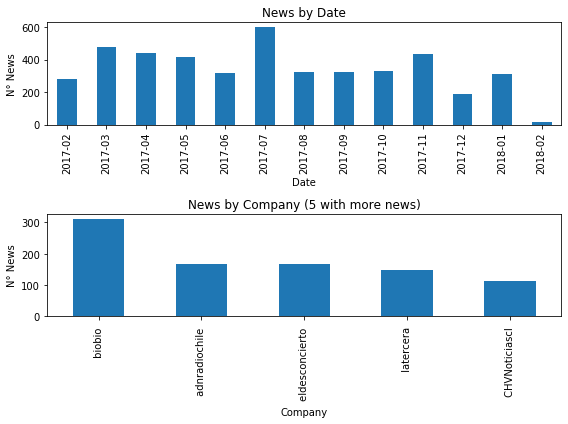

In [3]:
# Analize news by date
news_grouped_by_month = news.groupby(news.date.dt.to_period("M")).count()
news_per_month = news_grouped_by_month.news

#display(news_per_month)
fig1, axes = plt.subplots(2,1, figsize = (8,6))

ax1 = news_per_month.plot.bar(ax = axes[0], x = 'date', y = 'news')
ax1.set_xlabel("Date")
ax1.set_ylabel('N° News')
ax1.title.set_text('News by Date')
plt.tight_layout()

# Analize news by company
news_grouped_by_company = news.groupby(news.company).count()
#print(news_grouped_by_company.sort(['news']))

# Sort by number of news
news_grouped_by_company.sort_values(['date'], ascending=False, inplace = True)

top_companies = 5

news_per_company = news_grouped_by_company.news[0:top_companies]

top_20_companies = news_per_company.index

ax2 = news_per_company.plot.bar(ax = axes[1], x = 'company', y = 'News')
ax2.set_xlabel("Company")
ax2.set_ylabel('N° News')
ax2.title.set_text('News by Company (5 with more news)')
plt.tight_layout()

Del gráfico de noticias en función de la fecha, se tiene que para Julio existe un máximo número de noticias (Otra posible arista de exploración es analizar que sucede en esa fecha, probablemente haya ocurrido algún evento mediático).

Del gráfico de las noticias en función de la compañia, se tiene que el medio Bío Bío es quien posee más número de noticias de violencia comparado con los demás medios.

### Tokenizer

In [4]:
# Tokenizador

# Define own tokenizer
#import spacy

nlp = spacy.load('es_core_news_sm')

def own_tokenizer(sentence):
    
    tokens = []
    
    doc = nlp(sentence.lower().strip())
    
    for token in doc:
        
        # Filtering
        if not token.is_space and not token.is_stop and not token.is_punct and not token.is_digit and not token.like_num:
            
            # add token to list in lemma form
            tokens.append(token.lemma_)
            
    return tokens

In [12]:
# Stop words (not has information)
stop_words = ['a','e','i','o','u',' ','  ','   ','  ','$','  ','y', '-', 'q','c', 'nna', 'e', 'l', '=', '<', '>','x','href','/'
             ,'http://www.girovisual.cl', 'https://twitter.com/girovisualtv'  ,  'https://www.facebook.com/girovisualtv',
              'loading'  ,  'working'  ,  'playlists',
              'newsletter'  , 'recibir'  ,  'guioteca'  ,  'hoyxhoy.cl'  ,  'farox'  ,  'contáctenos'  ,  'soychile.cl'  ,  'correo'  ,  'entérate'  ,  'inmobiliario'  ,  'emol'  ,  'propiedad'  ,  'elegir'  ,  'suscríbete','autolocal.cl' 
             'the','server','was','not','found','to','this','error','requested','request','report','errordocument','server','encountered','trying','cc',
             'autolocal.cl','sa','web'  ,  'clic'  ,  'imagen'  ,  'bligoo.com'  ,  'firefox'  ,  'registrarse'  ,   'sesión' ]

# using stop words from library
stop_words_lib = get_stop_words('spanish')

# joining stop words
stop_words = stop_words + stop_words_lib

### Representación vectorial utilizando TFIDF Vectorizer

In [13]:
# Vectorizator
tfid_vectorizer = TfidfVectorizer(tokenizer = own_tokenizer, stop_words = stop_words, ngram_range = (1,1))

news_vector_tfidf = tfid_vectorizer.fit_transform(news['news'])

# Get features names
news_vector_features = tfid_vectorizer.get_feature_names()

/home/leo/Desktop/master_UACH/env/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['correar', 'haber', 'litro', 'ser', 'tener'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Se utiliza TF-IDF debido a mejor representación de documentos, ya que permite identificar palabras claves que permiten diferenciar claramente de los otros documentos.

### Clustering utilizando K-means

In [14]:
# Find optimal value of n° of clusters

# Training model

#from sklearn.cluster import KMeans

# Number of clusters
num_k = range(1,10)

# Inertia list
inertia = []

# Iter over each k value
for i in num_k:
    
    print('Iter: {0}'.format(i))
    
    # Set model
    model = KMeans(n_clusters = i, n_init=5)
    
    # Fit model
    model.fit(news_vector_tfidf)
    
    # add intertia of model
    inertia.append(model.inertia_)

Iter: 1
Iter: 2
Iter: 3
Iter: 4
Iter: 5
Iter: 6
Iter: 7
Iter: 8
Iter: 9


No handles with labels found to put in legend.


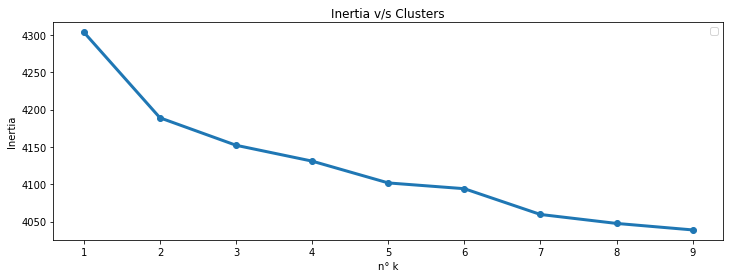

In [15]:
# plot inertia values

#import matplotlib.pyplot as plt

f, (ax) = plt.subplots(figsize = (12,4))
ax.plot(num_k, inertia, '-o', linewidth = 3)
ax.set_xlabel('n° k')
ax.set_ylabel('Inertia')
ax.title.set_text('Inertia v/s Clusters')
ax.legend()

Observando el gráfico, se tienen varios valores en donde la tasa de disminución disminuye, en donde el menor valor corresponde a 2, sin embargo, considerando el volumen de documentos, agrupar en sólo 2 cluster no sería óptimo, por lo que se definen 5 de clusters, ya que es el siguiente valor en donde se produce una disminución de la tasa de disminución.

In [16]:
# N° of clusters
k_k_means = 5

In [17]:
# Train model

# Set model
model = KMeans(n_clusters = k_k_means, init = 'k-means++', max_iter = 10, n_init = 10)

# Fit model
model.fit(news_vector_tfidf)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=10,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

Top Words per Topic: 

centroid 0: 
 
 violencia  ,  carabinero  ,  año  ,  robar  ,  intrafamiliar  ,  mujer  ,  delito  ,  víctima  ,  detener  ,  denunciar  ,  parejo  ,  hombre  ,  casar  ,  lesionar  ,  sujetar 

centroid 1: 
 
 violencia  ,  político  ,  gobernar  ,  presidente  ,  rincón  ,  chile  ,  derecho  ,  diputar  ,  candidato  ,  condenar  ,  senador  ,  araucanía  ,  país  ,  mapuche  ,  presidencial 

centroid 2: 
 
 mujer  ,  violencia  ,  género  ,  pololear  ,  víctima  ,  año  ,  parejo  ,  ley  ,  denunciar  ,  caso  ,  derecho  ,  joven  ,  equidad  ,  niño  ,  sexual 

centroid 3: 
 
 castaldi  ,  teta  ,  tea  ,  timar  ,  valentino  ,  henríquez  ,  camilo  ,  denunciar  ,  músico  ,  vocalista  ,  violencia  ,  banda  ,  parejo  ,  facebook  ,  acusación 

centroid 4: 
 
 ciudad  ,  futuro  ,  condicionar  ,  anunciar  ,  suceder  ,  término  ,  querer  ,  mundo  ,  sitiar  ,  periodístico  ,  chile  ,  empresa  ,  violencia  ,  publicar  ,  gestión 



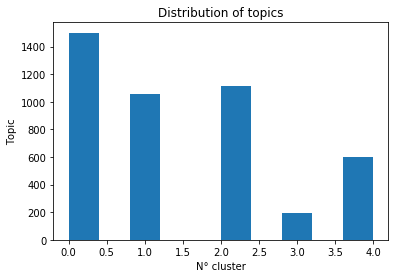

In [18]:
# Display top words

# Get order centroids
order_centroids = model.cluster_centers_.argsort()[:,::-1]

n_top_words = 15

print('Top Words per Topic: \n')

# Get principal words of each centroid
for i in range(0,k_k_means):
    
    centroid_words = np.array(news_vector_features)[order_centroids[i, 0:n_top_words]]
    
    print('centroid {0}: \n \n {1} \n'.format(i, '  ,  '.join(centroid_words)))

# Ploting results
labels = model.predict(news_vector_tfidf)

fig, ax = plt.subplots()

# TFIDF
#ax.scatter(range(labels.shape[0]),labels,c=labels)
ax.hist(labels)
ax.set_ylabel('Topic')
ax.set_xlabel('N° cluster')
ax.title.set_text('Distribution of topics')

Desde los tops words obtenidos por cada cluster, se puede inferir los siguientes tópicos asociados a cada cluster:

- Tópico 0: Violencia intrafamiliar
- Tópico 1: Violencia Mapuche
- Tópico 2: Violencia contra la mujer
- Tópico 3: Evento violencia vocalista 'Los Tetas'
- Tópico 4: No se identifica

Además, desde el gráfico de distribución de tópicos se tiene que la gran mayoría de las noticias corresponden a:

    a) Violencia intrafamiliar
    b) Violencia contra la mujer
    c) Violencia Mapuche

### Representación vectorial de documentos utilizando Count Vectorizer

In [19]:
# Vectorizacion de textos usando Count vectorizer

# from sklearn.feature_extraction.text import CountVectorizer
# Vector representation of news
count_vectorizer = CountVectorizer(tokenizer = own_tokenizer, stop_words = stop_words, ngram_range = (1,1))

# Count vectorizer
news_vector_count = count_vectorizer.fit_transform(news['news'])

# Get features names
news_vector_features = count_vectorizer.get_feature_names()

/home/leo/Desktop/master_UACH/env/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['correar', 'haber', 'litro', 'ser', 'tener'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


### Implementación modelo LDA utilizando Inferencia Variacional 

In [20]:
# find optimal number of topics

#from sklearn.decomposition import LatentDirichletAllocation
#import matplotlib.pyplot as plt

# Perplexity list
perp = []

# number of topics
num_topic = range(1,10)

# Iter over each value of topic
for topic in num_topic:
    
    print('Topic number {0} \n'.format(topic))
    
    # Define lda model
    lda = LatentDirichletAllocation(n_components = topic, max_iter = 10,
      learning_method = 'online',
      learning_offset = 50,
      random_state = 0)
    
    # Fit model
    lda.fit(news_vector_count)
    
    # add perplexity
    perp.append(lda.perplexity(news_vector_count))
    

Topic number 1 

Topic number 2 

Topic number 3 

Topic number 4 

Topic number 5 

Topic number 6 

Topic number 7 

Topic number 8 

Topic number 9 



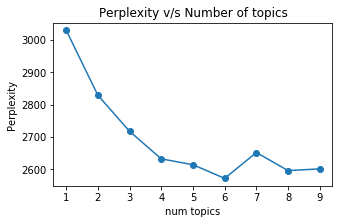

In [21]:
# Plot all k values
fig2, ax = plt.subplots(figsize = (5,3))
ax.plot(num_topic, perp, '-o')
ax.set_xlabel('num topics')
ax.set_ylabel('Perplexity')
ax.title.set_text('Perplexity v/s Number of topics')

Del gráfico se tiene que se definen 6 topicos, ya que para el 7 se observa aumento en perplexity.

In [22]:
# Define topics
topics = 6

In [23]:
# Training defined model 
#Generando algunos gráficos de los resultados

lda = LatentDirichletAllocation(n_components=topics, max_iter=50,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)

# (100, 7)
topic_distribution_per_documents = lda.fit_transform(news_vector_count)

print('Model fitted\n')


Model fitted



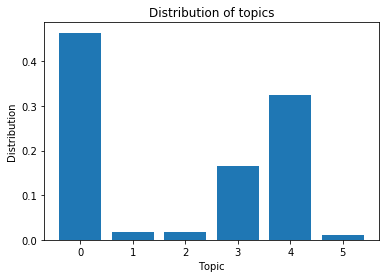

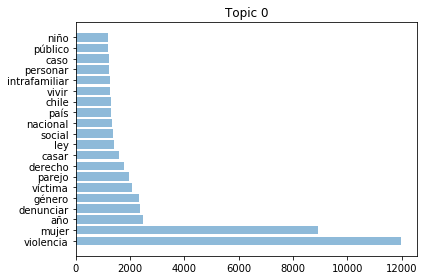

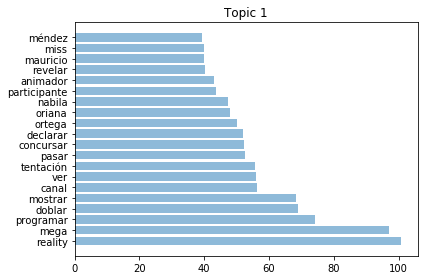

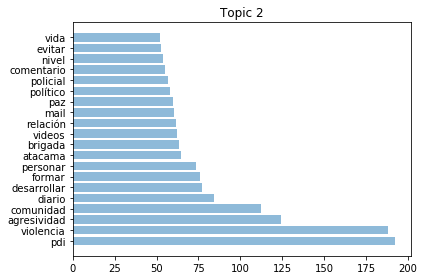

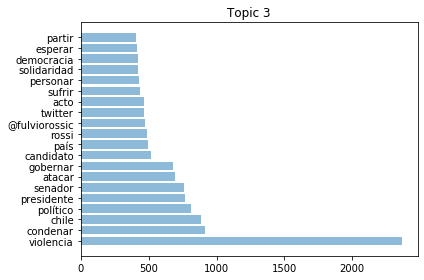

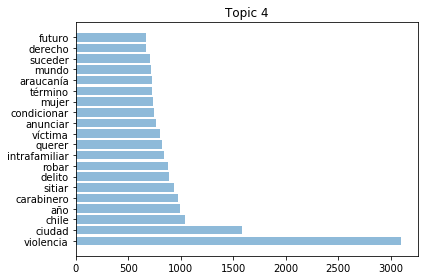

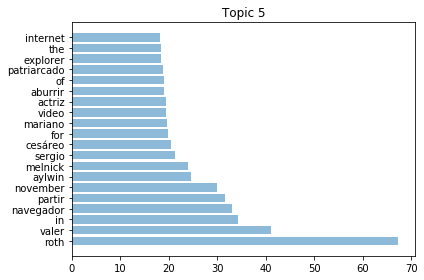

In [24]:
#distribución de tópicos en todos los documentos
dist_per_topic = sum(topic_distribution_per_documents)/len(news.news)

topics_array = np.arange(0,topics)

#plotting disttribution
fig, ax = plt.subplots()
ax.bar(topics_array, dist_per_topic)
ax.set_xlabel('Topic')
ax.set_ylabel('Distribution')
ax.title.set_text('Distribution of topics')

#distribución de tópicos en el documento 100
#plt.bar(topics_array,height=dist_per_topic,alpha=0.5,tick_label=topics_array)
#show()

#print(lda.components_.shape)
#frecuencia de palabras por tópico
n_top_words=20
numo =np.arange(0,n_top_words)
for idx,topic in enumerate(lda.components_):
    d =[]
    s = []
    for i in topic.argsort()[:-n_top_words - 1:-1]:
          s.append(news_vector_features[i])
          d.append(topic[i])
    plt.figure()
    plt.barh(numo,width=d,alpha=0.5,tick_label=s)
    plt.title('Topic ' + str(idx))
    plt.tight_layout()
    plt.show()


#### Respuesta a pregunta de investigación:

##### ¿Cuales son los temas mas relevantes que se expusieron en los medios durante 2017 sobre la temática violencia?

De las top-words de cada tópico, se logra indentificar los siguientes temas:

- Topic 0: Violencia contra la mujer
- Topic 1: Evento asociado a programa televisivo
- Topic 2: Violencia y Policia de Investigaciones
- Topic 3: Violencia y Política
- Topic 4: Violencia en la ciudad 
- Topic 5: Evento asociado a persona de televisión (Roth)

Desde el gráfico de distribución de tópicos, se tiene que los mayores temas desarrollados por los medios corresponden a:

1) Violencia contra la mujer.

2) Violencia en la ciudad

3) Violencia y Política

### Respuesta a pregunta de Investigación

##### ¿De qué temas relacionados a la violencia hablan los 5 medios con más noticias en Chile?

In [29]:
# Name to topic
topic_name = ['Violencia contra la mujer',
              'Evento asociado a programa televisivo',
              'Violencia y Policia de Investigaciones',
              'Violencia y Política',
              'Violencia en la ciudad ',
              'Evento asociado a persona de televisión (Roth)'
             ]

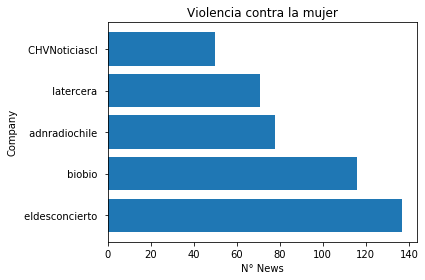

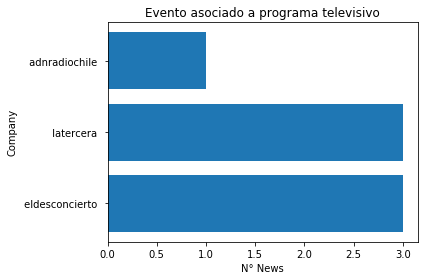

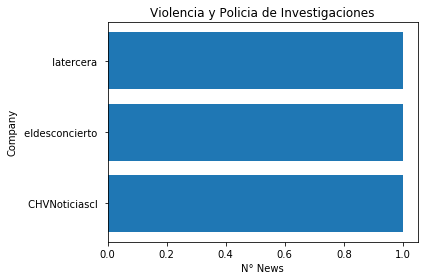

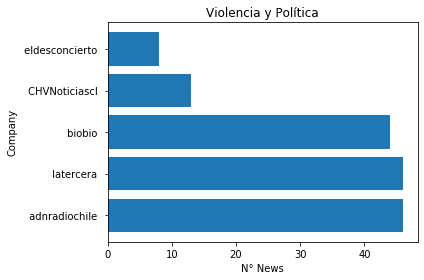

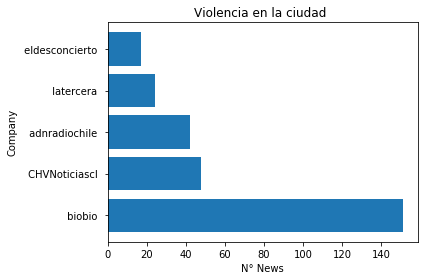

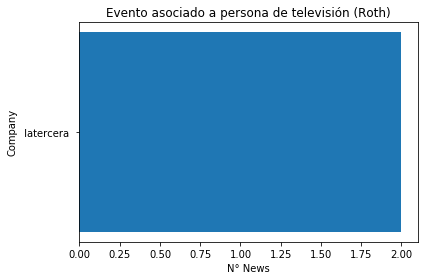

In [30]:
# Assign to each document the most frecuent topic
z=[]
for i in range(len(news.news)):
    z.append(np.argmax(topic_distribution_per_documents[i]))

# add a new variable to dataframe
news['topic'] = z

# iterate over each topic
for topic_num in range(0,topics):
    
    companies_per_topic = news[(news['company'].isin(top_20_companies)) & (news['topic'] == topic_num)].groupby('company').count().sort_values(['news'], ascending=False)
    plt.figure()
    plt.barh(y = companies_per_topic.index.values, width = companies_per_topic.news)
    plt.xlabel('N° News')
    plt.ylabel('Company')
    plt.title(str(topic_name[topic_num]))
    plt.tight_layout()


De los gráficos se observa que los medios que más hablan por cada tópico corresponden a:

- Violencia contra la mujer: El Desconcierto
- Evento asociado a progama televisivo: El Desconcierto, La Tercer (cabe destacar el poco número de noticias, por lo que conclusiones podrian no ser generales).
- Violencia y PDI: CHV Noticias, El Desconcierto, La Tercer (cabe destacar el poco número de noticias).
- Violencia y Política: ADN Radio y La Tercera.
- Violencia en la ciudad: Bio Bio.
- Evento asociado a persona de televisión: La Tercera (resultados no generales, ya que hay pocos datos).

Cabe destacar nuevamente que solamente se tomaron los 5 medios con más noticias, es por eso que en algunos tópicos existen pocos números de noticias (3 o menos).

Notar que en algunos tópicos existen muy pocos documentos (menores a 3 en algunos topicos), por lo que los resultados no son generalizables debido al bajo número.

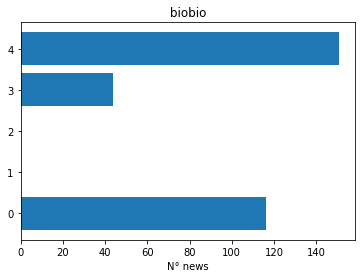

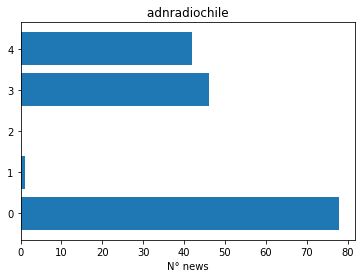

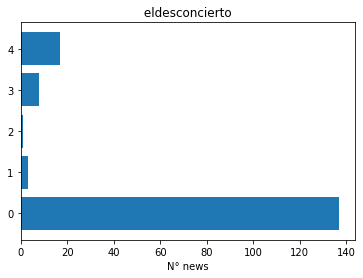

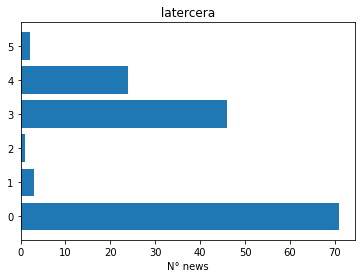

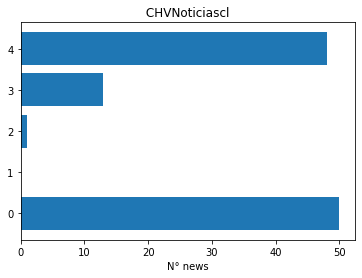

In [37]:
# Print distribution per medium

# for idx, medium in top_20_companies:
for num, medium in enumerate(top_20_companies):
    
    asd = news[(news['company'].isin(top_20_companies)) & (news.company == medium)].groupby('topic').count()
    
    plt.figure()
    
    plt.barh(y = asd.index.values, width = asd.news)
    
    #plt.barh(y = companies_per_topic.index.values, width = companies_per_topic.news)
    
    plt.xlabel('N° news')
    
    plt.title(medium)

De los gráficos se observa que cada medio habla principalmente de los siguientes temas:

- Bio Bio: Violencia en la ciudad, Violencia contra la mujer, Violencia y Política


- ADN Radio: Violencia contra la mujer, Violencia y Política, Violencia en la ciudad.


- El Desconcierto: Violencia contra la mujer (se destaca que la gran mayoría de noticias están en este tópico).


- La Tercera: Violencia contra la mujer, Violencia y Política, Violencia en la ciudad.


- CHV Noticias: Violencia contra la mujer, Violencia en la ciudad, Violencia y Política.

### Implementación modelo LDA utilizando Gibbs Sampling

In [26]:
import lda

model = lda.LDA(n_topics = topics, n_iter=10000, alpha=0.1, eta=0.1, random_state=3)
model.fit(news_vector_count)  # model.fit_transform(X) is also available

topic_word = model.topic_word_  # model.components_ also works

#n_top_words=10

#for i, topic_dist in enumerate(topic_word):
    
#    topic_words = np.array(news_vector_features)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    
#    print('Topic {}: {}'.format(i, ' '.join(topic_words)))

INFO:lda:n_documents: 4468
INFO:lda:vocab_size: 22899
INFO:lda:n_words: 591002
INFO:lda:n_topics: 6
INFO:lda:n_iter: 10000
/home/leo/Desktop/master_UACH/env/lib/python3.6/site-packages/lda/utils.py:55: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if sparse and not np.issubdtype(doc_word.dtype, int):
INFO:lda:<0> log likelihood: -5932944
INFO:lda:<10> log likelihood: -5147594
INFO:lda:<20> log likelihood: -4927270
INFO:lda:<30> log likelihood: -4862390
INFO:lda:<40> log likelihood: -4829561
INFO:lda:<50> log likelihood: -4812214
INFO:lda:<60> log likelihood: -4802186
INFO:lda:<70> log likelihood: -4795184
INFO:lda:<80> log likelihood: -4792049
INFO:lda:<90> log likelihood: -4788845
INFO:lda:<100> log likelihood: -4788651
INFO:lda:<110> log likelihood: -4788348
INFO:lda:<120> log likelihood: -4787252
INFO:lda:<130> log likelihood: -4786771
INFO:lda:<140> 

INFO:lda:<1920> log likelihood: -4783338
INFO:lda:<1930> log likelihood: -4783915
INFO:lda:<1940> log likelihood: -4783363
INFO:lda:<1950> log likelihood: -4783610
INFO:lda:<1960> log likelihood: -4782808
INFO:lda:<1970> log likelihood: -4783055
INFO:lda:<1980> log likelihood: -4783046
INFO:lda:<1990> log likelihood: -4782032
INFO:lda:<2000> log likelihood: -4783182
INFO:lda:<2010> log likelihood: -4782216
INFO:lda:<2020> log likelihood: -4781932
INFO:lda:<2030> log likelihood: -4781590
INFO:lda:<2040> log likelihood: -4782237
INFO:lda:<2050> log likelihood: -4783180
INFO:lda:<2060> log likelihood: -4784106
INFO:lda:<2070> log likelihood: -4781416
INFO:lda:<2080> log likelihood: -4783395
INFO:lda:<2090> log likelihood: -4781327
INFO:lda:<2100> log likelihood: -4780887
INFO:lda:<2110> log likelihood: -4782796
INFO:lda:<2120> log likelihood: -4782178
INFO:lda:<2130> log likelihood: -4782352
INFO:lda:<2140> log likelihood: -4783564
INFO:lda:<2150> log likelihood: -4784039
INFO:lda:<2160> 

INFO:lda:<3920> log likelihood: -4783822
INFO:lda:<3930> log likelihood: -4782174
INFO:lda:<3940> log likelihood: -4782467
INFO:lda:<3950> log likelihood: -4782389
INFO:lda:<3960> log likelihood: -4782144
INFO:lda:<3970> log likelihood: -4783575
INFO:lda:<3980> log likelihood: -4782644
INFO:lda:<3990> log likelihood: -4783259
INFO:lda:<4000> log likelihood: -4782761
INFO:lda:<4010> log likelihood: -4783057
INFO:lda:<4020> log likelihood: -4783222
INFO:lda:<4030> log likelihood: -4782318
INFO:lda:<4040> log likelihood: -4782257
INFO:lda:<4050> log likelihood: -4784036
INFO:lda:<4060> log likelihood: -4782492
INFO:lda:<4070> log likelihood: -4783098
INFO:lda:<4080> log likelihood: -4783481
INFO:lda:<4090> log likelihood: -4783434
INFO:lda:<4100> log likelihood: -4781424
INFO:lda:<4110> log likelihood: -4783830
INFO:lda:<4120> log likelihood: -4783388
INFO:lda:<4130> log likelihood: -4782788
INFO:lda:<4140> log likelihood: -4781248
INFO:lda:<4150> log likelihood: -4783449
INFO:lda:<4160> 

INFO:lda:<5920> log likelihood: -4781250
INFO:lda:<5930> log likelihood: -4782025
INFO:lda:<5940> log likelihood: -4781789
INFO:lda:<5950> log likelihood: -4782771
INFO:lda:<5960> log likelihood: -4782492
INFO:lda:<5970> log likelihood: -4782138
INFO:lda:<5980> log likelihood: -4783188
INFO:lda:<5990> log likelihood: -4783531
INFO:lda:<6000> log likelihood: -4780935
INFO:lda:<6010> log likelihood: -4782959
INFO:lda:<6020> log likelihood: -4782772
INFO:lda:<6030> log likelihood: -4781093
INFO:lda:<6040> log likelihood: -4783698
INFO:lda:<6050> log likelihood: -4783621
INFO:lda:<6060> log likelihood: -4782182
INFO:lda:<6070> log likelihood: -4782612
INFO:lda:<6080> log likelihood: -4783413
INFO:lda:<6090> log likelihood: -4783745
INFO:lda:<6100> log likelihood: -4783339
INFO:lda:<6110> log likelihood: -4783827
INFO:lda:<6120> log likelihood: -4782279
INFO:lda:<6130> log likelihood: -4782936
INFO:lda:<6140> log likelihood: -4783480
INFO:lda:<6150> log likelihood: -4783268
INFO:lda:<6160> 

INFO:lda:<7920> log likelihood: -4782734
INFO:lda:<7930> log likelihood: -4783940
INFO:lda:<7940> log likelihood: -4781688
INFO:lda:<7950> log likelihood: -4782701
INFO:lda:<7960> log likelihood: -4782032
INFO:lda:<7970> log likelihood: -4782905
INFO:lda:<7980> log likelihood: -4782082
INFO:lda:<7990> log likelihood: -4782057
INFO:lda:<8000> log likelihood: -4782048
INFO:lda:<8010> log likelihood: -4783666
INFO:lda:<8020> log likelihood: -4783568
INFO:lda:<8030> log likelihood: -4784232
INFO:lda:<8040> log likelihood: -4782937
INFO:lda:<8050> log likelihood: -4782973
INFO:lda:<8060> log likelihood: -4782237
INFO:lda:<8070> log likelihood: -4782733
INFO:lda:<8080> log likelihood: -4781704
INFO:lda:<8090> log likelihood: -4782908
INFO:lda:<8100> log likelihood: -4782575
INFO:lda:<8110> log likelihood: -4781881
INFO:lda:<8120> log likelihood: -4782376
INFO:lda:<8130> log likelihood: -4782785
INFO:lda:<8140> log likelihood: -4782201
INFO:lda:<8150> log likelihood: -4782662
INFO:lda:<8160> 

INFO:lda:<9920> log likelihood: -4782611
INFO:lda:<9930> log likelihood: -4783280
INFO:lda:<9940> log likelihood: -4783257
INFO:lda:<9950> log likelihood: -4783260
INFO:lda:<9960> log likelihood: -4781845
INFO:lda:<9970> log likelihood: -4783027
INFO:lda:<9980> log likelihood: -4782937
INFO:lda:<9990> log likelihood: -4782008
INFO:lda:<9999> log likelihood: -4782352


In [27]:
n_top_words=15

for i, topic_dist in enumerate(topic_word):
    
    topic_words = np.array(news_vector_features)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))

Topic 0: violencia mujer nabila hombre personar vivir social género casar año denunciar rifar víctima vida parejo
Topic 1: ciudad violencia chile término mundo sitiar querer anunciar condicionar suceder futuro denunciar valentino castaldi teta
Topic 2: violencia chile país gobernar derecho presidente araucanía región político santiago mapuche personar llamar grupo nacional
Topic 3: violencia mujer género año víctima ley nacional pololear denunciar caso derecho parejo país niño joven
Topic 4: violencia senador condenar político mujer diputar derecho candidato atacar chile rossi esperar @fulviorossic rincón sufrir
Topic 5: violencia año carabinero intrafamiliar delito víctima mujer casar denunciar robar parejo detener lesionar hombre hecho


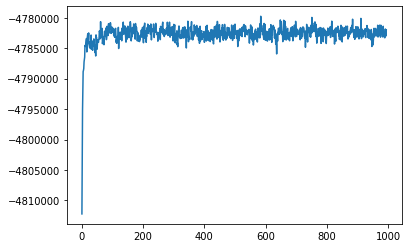

In [28]:
plt.plot(model.loglikelihoods_[5:])

El algoritmo converge ya que se mantiene pendiente constante para valores superiores a 200.

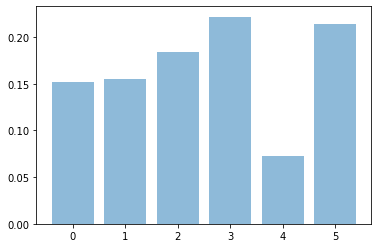

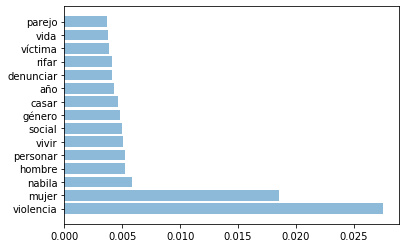

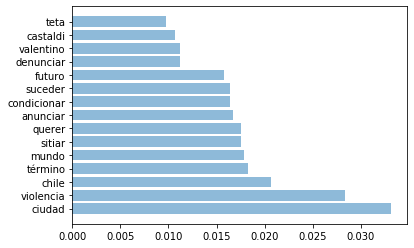

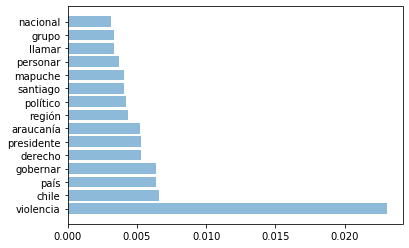

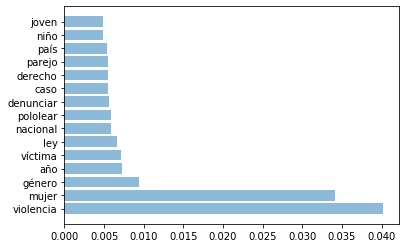

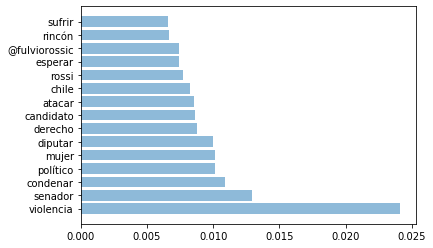

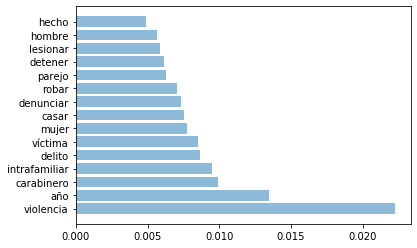

In [38]:
#Generando algunos gráficos de los resultados
#from matplotlib.pylab import hist, show

y = model.doc_topic_
#distribución de tópicos en todos los documentos
dist = sum(y)/len(news.news)

w=np.arange(0,topics)

plt.bar(w,height=dist,alpha=0.5,tick_label=w)

plt.show()

#frecuencia de palabras por tópico
n_top_words=15
numo =np.arange(0,n_top_words)

for idx,topic in enumerate(model.topic_word_):
    d =[]
    s = []
    for i in topic.argsort()[:-n_top_words - 1:-1]:
          s.append(news_vector_features[i])
          d.append(topic[i])
    
    plt.barh(numo,width=d,alpha=0.5,tick_label=s)
    plt.show()



De los gráficos de topwords, se infieren los siguientes tópicos:

- Tópico 0: Evento violencia mujer (Nabila Rifo)
- Topico 1: Violencia en la ciudad
- Tópico 2: Violencia Política y Mapuches
- Tópico 3: Violencia conta la mujer 
- Tópico 4: Evento violencia asociado a político.
- Tópico 5: Violencia Intrafamiliar

Respecto a la distribución de tópicos en los documentos, se tiene que los mayores temas  corresponden a:

1) Violencia Intrafamiliar.

2) Violencia contra la mujer.

3) Violencia Política y Mapuches.

4) Violencia en la ciudad.

5) Evento violencia mujer (Nabila Rifo)

Se destaca una distribución similar por tópicos obtenida, la que es diferente al método LDA Bayes, ya que en éste se obtiene una distribución no uniforme.

### Comparación resultados obtenidos por modelos

Respecto al número de clusters se tiene:

- K-means: 5 tópicos.
- LDA Bayesian: 6 tópicos.
- LDA Gibbs: 6 tópicos.

Por lo tanto, según los diferentes métodos, cada algoritmo logra identificar diferentes números de tópicos en las noticias.

Con respecto a los temas identificados por tópicos, se tiene lo siguiente:

- K-means:
   
    - Tópico 0: Violencia intrafamiliar
    - Tópico 1: Violencia Mapuche
    - Tópico 2: Violencia contra la mujer
    - Tópico 3: Evento violencia vocalista 'Los Tetas'
    - Tópico 4: No se identifica

    
- LDA Bayesian:
    - Topic 0: Violencia contra la mujer
    - Topic 1: Evento asociado a programa televisivo
    - Topic 2: Violencia y Policia de Investigaciones
    - Topic 3: Violencia y Política
    - Topic 4: Violencia en la ciudad 
    - Topic 5: Evento asociado a persona de televisión (Roth)

    
    
- LDA Gibbs:

    - Tópico 0: Evento violencia mujer (Nabila Rifo)
    - Topico 1: Violencia en la ciudad
    - Tópico 2: Violencia Política y Mapuches
    - Tópico 3: Violencia conta la mujer 
    - Tópico 4: Evento violencia asociado a político.
    - Tópico 5: Violencia Intrafamiliar

El tópico que se repite (explicitamente) en todos los resultados corresponde a Violencia conta la mujer (Recordar que el tópico fué obtenido por analista, por lo que es subjetivo). 

Los tópicos que se dan en varios resultados corresponden a:

- Violencia Intrafamiliar
- Violencia y Mapuches
- Violencia y Política
- Violencia en la ciudad

Los temas que solo se presentan en un único agrupamiento:

- Evento asociado a grupo 'Los Tetas'
- Evento asociado a programa televisivo
- Violencia y PDI
- Evento violencia persona de televisión.
- Evento violencia a político

Se vuelve a destacar que se hicieron comparaciones basados en el tópico entregado por analista, por lo que pueden haber grupos que quedaron excluidos pero sin embargo pueden tener palabras similares como topwords.

Cabe destacar que para propósitos de esta investigación, se asigna un tópico a cada documento, no considerando la distribución entregada por LDA, la cual es una ventaja sobre K-means y la cual es útil para otras implementaciones.

Respecto a la pregunta de investigación sobre que temas se hablaron en los medios para el 2017, se tiene lo siguiente:

- K-means: 

    1) Violencia intrafamiliar

    2) Violencia contra la mujer

    3) Violencia Mapuche
    
    
- LDA Bayesian: 

   1) Violencia contra la mujer.

    2) Violencia en la ciudad

    3) Violencia y Política

    
- LDA Gibbs:

    1) Violencia Intrafamiliar.

    2) Violencia contra la mujer.

    3) Violencia Política y Mapuches.

    4) Violencia en la ciudad.

    5) Evento violencia mujer (Nabila Rifo)
    
Los temas que mas se repiten entre métodos corresponden a 'Violencia intrafamiliar', 'Violencia contra la mujer' y 'Violencia, Política y Mapuches'.

Con respecto a la 2 pregunta de investigación (Tópicos expuestos por los 5 mayores medios), sólo se analiza utilizando LDA Bayesian, ya que la división de tópicos fué mas clara para el analista autor de esta investigación. Los resultados corresponden a:

- Bio Bio: Violencia en la ciudad, Violencia contra la mujer, Violencia y Política


- ADN Radio: Violencia contra la mujer, Violencia y Política, Violencia en la ciudad.


- El Desconcierto: Violencia contra la mujer (se destaca que la gran mayoría de noticias están en este tópico).


- La Tercera: Violencia contra la mujer, Violencia y Política, Violencia en la ciudad.


- CHV Noticias: Violencia contra la mujer, Violencia en la ciudad, Violencia y Política.
